In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset

In [19]:
train = pd.read_csv('train.csv', parse_dates=['date'])
stores = pd.read_csv('stores.csv')
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
oil = pd.read_csv('oil.csv', parse_dates=['date'])
transactions = pd.read_csv('transactions.csv', parse_dates=['date'])

# Perfoming EDA Analysis

In [24]:
# Merging stores and holidays info with the training data
df = train.merge(stores, on='store_nbr', how='left')
df = df.merge(holidays, on='date', how='left', suffixes=('', '_holiday'))

In [26]:
df['type_holiday'] = df['type_holiday'].fillna('Normal Day')
df['locale'] = df['locale'].fillna('Local')
df['locale_name'] = df['locale_name'].fillna('None')
df['description'] = df['description'].fillna('None')

print(df.head())
#filling nan values here

   id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type  cluster type_holiday    locale locale_name         description  \
0    D       13      Holiday  National     Ecuador  Primer dia del ano   
1    D       13      Holiday  National     Ecuador  Primer dia del ano   
2    D       13      Holiday  National     Ecuador  Primer dia del ano   
3    D       13      Holiday  National     Ecuador  Primer dia del ano   
4    D       13      Holiday  National     Ecuador  Primer dia del ano   

  transferred  
0       False  
1       False  
2       False  
3   

In [27]:

df = df.sort_values(by=['store_nbr', 'family', 'date'])


df = pd.get_dummies(df, columns=['type_holiday', 'locale'], drop_first=True)

print("Data preprocessed and sorted.")
df.info()

Data preprocessed and sorted.
<class 'pandas.core.frame.DataFrame'>
Index: 3054348 entries, 0 to 3054215
Data columns (total 21 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   date                     datetime64[ns]
 2   store_nbr                int64         
 3   family                   object        
 4   sales                    float64       
 5   onpromotion              int64         
 6   city                     object        
 7   state                    object        
 8   type                     object        
 9   cluster                  int64         
 10  locale_name              object        
 11  description              object        
 12  transferred              object        
 13  type_holiday_Bridge      bool          
 14  type_holiday_Event       bool          
 15  type_holiday_Holiday     bool          
 16  type_holiday_Normal Day  bool          
 17  ty

# Feature Engineering

### 1. Time-Based Features

In [35]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
df['day_of_week'] = df['date'].dt.dayofweek 
#Here ive taken Monday=0, Sunday=6

### 2. Lag Features (e.g., sales from 7 days ago)

In [32]:
# We group by store and product family to calculate lags correctly
df['sales_lag_7'] = df.groupby(['store_nbr', 'family'])['sales'].shift(7)
df['sales_lag_28'] = df.groupby(['store_nbr', 'family'])['sales'].shift(28)

### 3. Rolling Averages (e.g., 7-day moving average of sales)

In [33]:
df['sales_rolling_mean_7'] = df.groupby(['store_nbr', 'family'])['sales'].rolling(window=7).mean().reset_index(level=[0,1], drop=True)
df['sales_rolling_mean_28'] = df.groupby(['store_nbr', 'family'])['sales'].rolling(window=28).mean().reset_index(level=[0,1], drop=True)

In [36]:
# Fill any NaNs created by lags/rolling features
#Hence fuurther cleansing of data
df.fillna(0, inplace=True)

print(df[['date', 'store_nbr', 'family', 'sales', 'sales_lag_7', 'sales_rolling_mean_7']].head(10))

            date  store_nbr      family  sales  sales_lag_7  \
0     2013-01-01          1  AUTOMOTIVE    0.0          0.0   
1782  2013-01-02          1  AUTOMOTIVE    2.0          0.0   
3564  2013-01-03          1  AUTOMOTIVE    3.0          0.0   
5346  2013-01-04          1  AUTOMOTIVE    3.0          0.0   
7128  2013-01-05          1  AUTOMOTIVE    5.0          0.0   
8910  2013-01-06          1  AUTOMOTIVE    2.0          0.0   
10692 2013-01-07          1  AUTOMOTIVE    0.0          0.0   
12474 2013-01-08          1  AUTOMOTIVE    2.0          0.0   
14256 2013-01-09          1  AUTOMOTIVE    2.0          2.0   
16038 2013-01-10          1  AUTOMOTIVE    2.0          3.0   

       sales_rolling_mean_7  
0                  0.000000  
1782               0.000000  
3564               0.000000  
5346               0.000000  
7128               0.000000  
8910               0.000000  
10692              2.142857  
12474              2.428571  
14256              2.428571  
16038 

# Modeling

In [38]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

cutoff_date = '2017-07-15'
train_df = df[df['date'] <= cutoff_date]
val_df = df[df['date'] > cutoff_date]

features = [
    'store_nbr', 'year', 'month', 'week_of_year', 'day_of_week',
    'onpromotion', 'sales_lag_7', 'sales_lag_28',
    'sales_rolling_mean_7', 'sales_rolling_mean_28'
]

target = 'sales'

X_train = train_df[features]
y_train = train_df[target]
X_val = val_df[features]
y_val = val_df[target]


model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1,
    early_stopping_rounds=50,
    eval_metric='rmse'  ####
)

print("Training XGBoost model...")
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          verbose=True)

Training XGBoost model...
[0]	validation_0-rmse:1223.71143
[1]	validation_0-rmse:1165.00667
[2]	validation_0-rmse:1109.38965
[3]	validation_0-rmse:1056.67060
[4]	validation_0-rmse:1006.66946
[5]	validation_0-rmse:959.38526
[6]	validation_0-rmse:914.24035
[7]	validation_0-rmse:871.61991
[8]	validation_0-rmse:831.27577
[9]	validation_0-rmse:792.97974
[10]	validation_0-rmse:756.88179
[11]	validation_0-rmse:722.62398
[12]	validation_0-rmse:690.55414
[13]	validation_0-rmse:659.77746
[14]	validation_0-rmse:630.78127
[15]	validation_0-rmse:603.25425
[16]	validation_0-rmse:577.62249
[17]	validation_0-rmse:553.30983
[18]	validation_0-rmse:530.67725
[19]	validation_0-rmse:509.05663
[20]	validation_0-rmse:488.66441
[21]	validation_0-rmse:469.64079
[22]	validation_0-rmse:451.67188
[23]	validation_0-rmse:434.88866
[24]	validation_0-rmse:418.90501
[25]	validation_0-rmse:404.57567
[26]	validation_0-rmse:390.40219
[27]	validation_0-rmse:377.88757
[28]	validation_0-rmse:365.88462
[29]	validation_0-rmse

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

Validation MAE: 67.4412
Validation RMSE: 225.3146


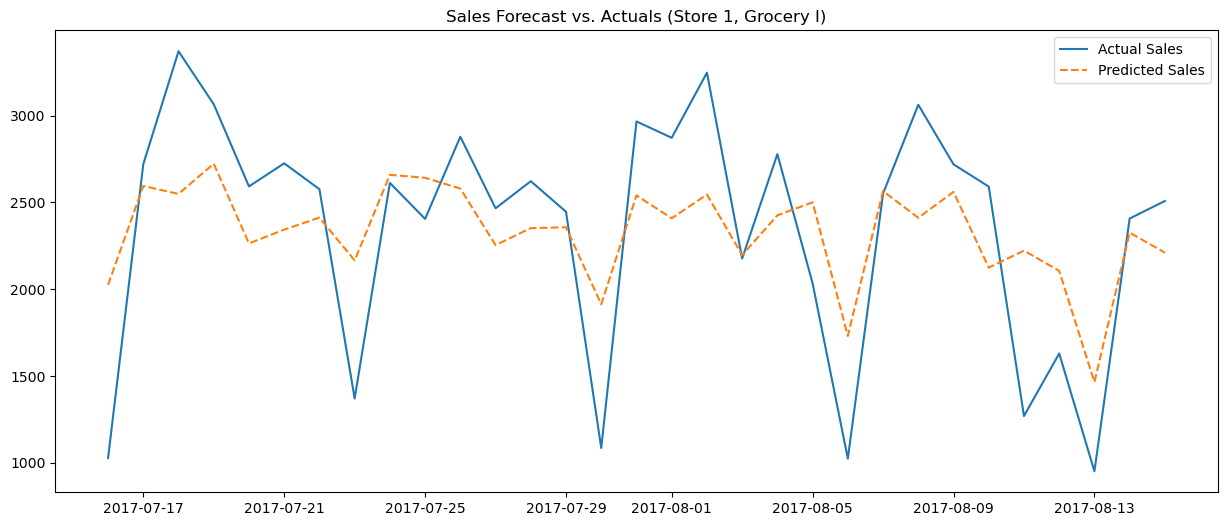

In [53]:
predictions = model.predict(X_val)

# Calculate metrics
mae = mean_absolute_error(y_val, predictions)
rmse = np.sqrt(mean_squared_error(y_val, predictions))

print(f"Validation MAE: {mae:.4f}")
print(f"Validation RMSE: {rmse:.4f}")

#Visualizing predictions vs. actuals for a specific store/family
plt.figure(figsize=(15, 6))
sample = val_df[(val_df['store_nbr'] == 1) & (val_df['family'] == 'GROCERY I')]
sample_preds = model.predict(sample[features])

plt.plot(sample['date'], sample['sales'], label='Actual Sales')
plt.plot(sample['date'], sample_preds, label='Predicted Sales', linestyle='--')
plt.title('Sales Forecast vs. Actuals (Store 1, Grocery I)')
plt.legend()
plt.show()

# 

# Saving the trained model to a file

In [39]:
import joblib
joblib.dump(model, 'sales_forecast_model.pkl')

['sales_forecast_model.pkl']

# Work on app.py from here onwards

In [50]:
import streamlit as st
import pandas as pd
import joblib

In [52]:
# Load the trained model
model = joblib.load('sales_forecast_model.pkl')

st.title('Retail Sales Forecasting Dashboard 🛒')

# Create inputs for user to select store, etc.
store_choice = st.selectbox('Select a Store:', options=list(range(1, 55)))
family_choice = st.selectbox('Select a Product Family:', options=['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING']) # Add more families


if st.button('Forecast Sales'):


    future_data = pd.DataFrame({
        'store_nbr': [store_choice],
        'family': [family_choice],

    })



    st.write(f"This is a placeholder for the forecast for **{family_choice}** at **Store {store_choice}**.")
    st.success(f"Forecasted Sales for the next week: $YYYY.YY") 

2025-08-28 18:56:09.319 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-28 18:56:09.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-28 18:56:09.321 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-28 18:56:09.322 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-28 18:56:09.323 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-28 18:56:09.323 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-28 18:56:09.325 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-28 18:56:09.325 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar